## This notebook is our reseach for knowledge tracing using Tensorflow

### ML Scientist/Engineer Team
- Muhammad Adisatriyo Pratama
- Jonathan Elloy

## Import Library

In [1]:
# file path
# dataset on Google Cloud Storage
from google.cloud import storage

bucket_path = 'gs://bangkit-capstone0482-bucket/dataset/'


In [2]:
# import basic library
import numpy as np 
import pandas as pd 


import os

In [3]:
# import Tensorflow and other essential ML 
from tensorflow.keras.layers import Dense , BatchNormalization , Dropout , Input
from tensorflow.keras.models import Model , Sequential
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

## Prepare Dataset

### train data

In [4]:
# read csv and convert the datatype
train=pd.read_csv(bucket_path + 'train.csv',dtype={'row_id':'int64',\
                                                   'timestamp':'int64',\
                                                   'user_id':'int32',\
                                                   'content_id':'int16',\
                                                   'content_type_id':'int8',\
                                                   'task_container_id':'int16',\
                                                   'user_answer':'int8',\
                                                   'answered_correctly':'int8',\
                                                   'prior_question_elapsed_time':'float32',\
                                                   'prior_question_had_explanation':'boolean'})

In [5]:
# check the data
train.head()

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
0,0,0,115,5692,0,1,3,1,NaN,<NA>
1,1,56943,115,5716,0,2,2,1,37000.0,False
2,2,118363,115,128,0,0,0,1,55000.0,False
3,3,131167,115,7860,0,3,0,1,19000.0,False
4,4,137965,115,7922,0,4,1,1,11000.0,False


In [6]:
# change bool to int
train["prior_question_had_explanation"] = train["prior_question_had_explanation"].fillna(False).astype('int8')

In [7]:
train.head()

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
0,0,0,115,5692,0,1,3,1,NaN,0
1,1,56943,115,5716,0,2,2,1,37000.0,0
2,2,118363,115,128,0,0,0,1,55000.0,0
3,3,131167,115,7860,0,3,0,1,19000.0,0
4,4,137965,115,7922,0,4,1,1,11000.0,0


In [8]:
train.drop(0, axis=0, inplace=True)
train.reset_index()
train.head()

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
1,1,56943,115,5716,0,2,2,1,37000.0,0
2,2,118363,115,128,0,0,0,1,55000.0,0
3,3,131167,115,7860,0,3,0,1,19000.0,0
4,4,137965,115,7922,0,4,1,1,11000.0,0
5,5,157063,115,156,0,5,2,1,5000.0,0


In [9]:
# read question dataset
question_df=pd.read_csv(bucket_path + "questions.csv")
question_df.head()

,question_id,bundle_id,correct_answer,part,tags
0,0,0,0,1,51 131 162 38
1,1,1,1,1,131 36 81
2,2,2,0,1,131 101 162 92
3,3,3,0,1,131 149 162 29
4,4,4,3,1,131 5 162 38


### Pre-process question_df

In [10]:
question_df["tags"]=question_df["tags"].astype("str")

In [11]:
question_df["tags"]= question_df.tags.str.split()

In [12]:
tags=[elt  for tag in question_df["tags"].values for elt in tag]

In [13]:
tags=list(set(tags))

In [14]:
df=pd.DataFrame({elt:[1 if elt in li else 0 for li in question_df["tags"]] for elt in tags})

### Cluster the question tags

In [15]:
kmeans = KMeans(n_clusters=10)

In [16]:
kmeans.fit(df)

KMeans(n_clusters=10)

In [17]:
question_df["tags"] = kmeans.labels_

In [18]:
# question after clustering
question_df.head()

,question_id,bundle_id,correct_answer,part,tags
0,0,0,0,1,4
1,1,1,1,1,6
2,2,2,0,1,3
3,3,3,0,1,4
4,4,4,3,1,4


In [19]:
question_df

,question_id,bundle_id,correct_answer,part,tags
0,0,0,0,1,4
1,1,1,1,1,6
2,2,2,0,1,3
3,3,3,0,1,4
4,4,4,3,1,4
...,...,...,...,...,...
13518,13518,13518,3,5,0
13519,13519,13519,3,5,0
13520,13520,13520,2,5,0
13521,13521,13521,0,5,0


In [20]:
del(df)

In [21]:
del(question_df["bundle_id"])
del(question_df["correct_answer"])
del(question_df["part"])

In [22]:
question_df.head()

,question_id,tags
0,0,4
1,1,6
2,2,3
3,3,4
4,4,4


In [23]:
question_df.rename(columns={"question_id":"content_id"},inplace=True)

In [24]:
question_df.set_index("content_id" , inplace = True)

### Merge question_df with train data

In [25]:
train = pd.concat([train.reset_index(drop=True),question_df.reindex(train["content_id"].values)\
                  .reset_index(drop=True)] , axis=1)

In [26]:
train.head()

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,tags
0,1,56943,115,5716,0,2,2,1,37000.0,0,0.0
1,2,118363,115,128,0,0,0,1,55000.0,0,3.0
2,3,131167,115,7860,0,3,0,1,19000.0,0,6.0
3,4,137965,115,7922,0,4,1,1,11000.0,0,3.0
4,5,157063,115,156,0,5,2,1,5000.0,0,4.0


### Create user df

In [27]:
users=train[["user_id","tags","answered_correctly"]].\
groupby(["user_id","tags"]).agg({"answered_correctly":["mean","count"]})

In [28]:
users.columns=["mean_user","count_user"]

In [29]:
us=users.copy()

In [30]:
us=us.reset_index(drop=False)

In [31]:
us=us[["user_id","tags"]]

In [32]:
us=us.pivot(index="user_id",columns="tags",values="tags")

In [33]:
question=train[["content_id","answered_correctly"]].\
groupby(["content_id"]).agg({"answered_correctly":["mean"]})

In [34]:
question.columns=["mean_question"]

In [35]:
tr=train.sample(frac=0.2,random_state=1)

In [36]:
tr = tr.merge(users , how="left" ,left_on=["user_id","tags"] ,right_index=True)

In [37]:
tr = pd.concat([tr.reset_index(drop=True),question.reindex(tr['content_id'].values).reset_index(\
                                                                                               drop=True)],axis=1)

In [38]:
del(tr["row_id"])
del(tr["user_id"])
del(tr["content_id"])
del(tr["content_type_id"])
del(tr["user_answer"])
del(tr["task_container_id"])
del(tr["tags"])

In [39]:
features=["timestamp","prior_question_elapsed_time","prior_question_had_explanation","mean_user",\
         "count_user","mean_question"]

In [40]:
target= "answered_correctly"

In [41]:
tr = tr.replace([np.inf, -np.inf], np.nan)

In [42]:
tr["mean_user"].fillna(0.5,inplace=True)
tr["mean_question"].fillna(0.5,inplace=True)
tr["count_user"].fillna(1,inplace=True)
tr.fillna(0,inplace=True)

<h2> Tensorflow Model </h2>

In [43]:
## Create model funciton
def create_model(sh):
    inp=Input(sh)
    md=BatchNormalization()(inp)
    md=Dense(128,activation='relu') (md)
    md=BatchNormalization()(md)
    md=Dropout(0.3) (md)
    md=Dense(64,activation='relu') (md)
    md=BatchNormalization()(md)
    md=Dropout(0.4) (md)
    md=Dense(32,activation='relu') (md)
    md= BatchNormalization() (md)
    md=Dropout(0.4) (md)
    md= Dense(1, activation="sigmoid") (md)
    
    mod=Model(inputs=[inp],outputs=[md])
    
    return mod 

In [44]:
X=tr[features]
Y=tr[[target]]

In [45]:
del(tr)

In [46]:
sh=X.shape[1]

In [47]:
xtr,xts,ytr,yts=train_test_split(X,Y,test_size=0.2,stratify=Y)

In [48]:
del(X)
del(Y)

In [49]:
model = create_model(sh)
model.compile(loss= "binary_crossentropy",metrics=["accuracy"],optimizer="adam")

In [50]:
hist = model.fit(xtr,ytr,validation_split=0.2,epochs=10,batch_size=1024)

Epoch 1/10
12654/12654 [==============================] - 313s 25ms/step - loss: -345.6607 - accuracy: 0.6239 - val_loss: -887.0952 - val_accuracy: 0.7039
Epoch 2/10
12654/12654 [==============================] - 328s 26ms/step - loss: -1999.4045 - accuracy: 0.6198 - val_loss: -2991.6345 - val_accuracy: 0.6754
Epoch 3/10
12654/12654 [==============================] - 318s 25ms/step - loss: -4995.8394 - accuracy: 0.6205 - val_loss: -5374.7402 - val_accuracy: 0.7053
Epoch 4/10
12654/12654 [==============================] - 303s 24ms/step - loss: -9294.6816 - accuracy: 0.6193 - val_loss: -9577.9512 - val_accuracy: 0.7067
Epoch 5/10
12654/12654 [==============================] - 320s 25ms/step - loss: -14913.1992 - accuracy: 0.6187 - val_loss: -14349.9199 - val_accuracy: 0.6535
Epoch 6/10
12654/12654 [==============================] - 326s 26ms/step - loss: -21848.0195 - accuracy: 0.6194 - val_loss: -20137.6250 - val_accuracy: 0.7092
Epoch 7/10
12654/12654 [==============================] 

In [51]:
ypred = model.predict(xts)
ypred

array([[1.],
       [1.],
       [1.],
       ...,
       [1.],
       [1.],
       [1.]], dtype=float32)

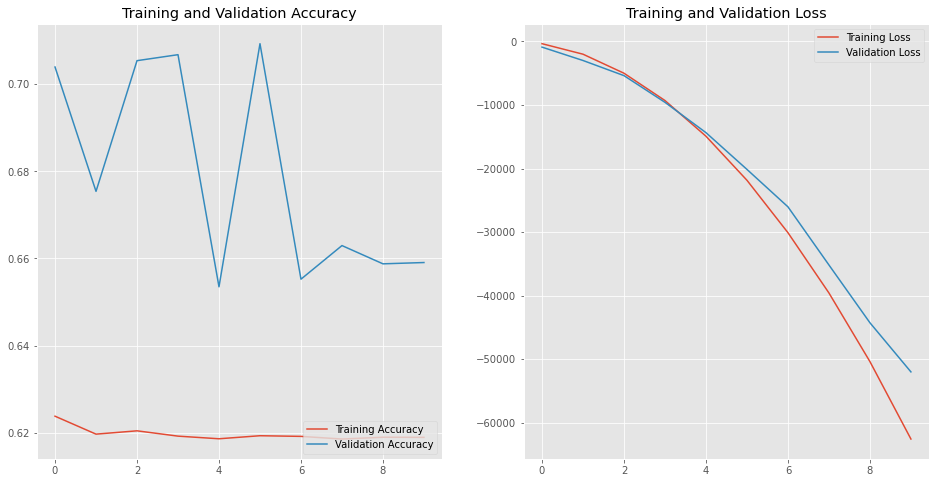

In [52]:
## plotting
plt.style.use('ggplot')
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']

loss = hist.history['loss']
val_loss = hist.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [54]:
model.save('model.h5')